In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Получение модели оплаты 2021-2023
Получим цены с [официального сайта](https://www.divvybikes.com/pricing) и соответственно построим тариф:
## Для member пользователей:
- поездки 45- минут на классических велосипедах - бесплатно
- поездки 45+ минут на классических велосипедах - 0.17 доллара за минуты выше тарифа
- поездки на электрических велосипедах - 0.17 доллара за минуту
- **Вне зависимости от поездок** - 130.90 доллара в год

## Для casual пользователей:
- поездки 30- минут на классических велосипедах - бесплатно
- поездки 30+ минут на классических велосипедах - 0.17 доллара за минуты выше тарифа
- поездки на электрических велосипедах - 0.42 доллара за минуту
- **Вне зависимости от длительности и типа велосипеда** - 1 доллар за разблокировку

За потерю велосипеда штраф 1200 долларов

Для упрощения расчетов, сделаем следующие предположения:
- Велосипеды, которые были взяты и не были возвращены - найденные велосипеды
- Велосипеды, которые были взяты и не были возвращены - потерянные велосипеды

Тогда количество потерянных велосипедов = потерянные велосипеды - найденные велосипеды. При этом понятно что штраф платить будут не всегда, поэтому предположим что только половина штрафов будет платиться.

In [2]:
result_sums = []

for year in range(2020, 2024):
    df = pd.read_csv(f"data/{year}/Divvy_Trips_{year}_full.csv.gz", compression="gzip")
    df.drop(
        columns=[
            "start_station_id",
            "end_station_id",
            "start_lat",
            "start_lng",
            "end_lat",
            "end_lng",
        ],
        inplace=True,
    )
    # Колонка с длительностью поездки
    df["duration"] = pd.to_datetime(df["ended_at"]) - pd.to_datetime(df["started_at"])
    # Переводим в минуты
    df["duration"] = round(df["duration"].dt.total_seconds().div(60), 1)
    found_df = df[df["start_station_name"].isna()]
    lost_df = df[df["end_station_name"].isna()]
    # Считаем итоговое количество потерянных велосипедов
    lost_bikes = lost_df["ride_id"].count() - found_df["ride_id"].count()
    # Для основного подсчета надо убрать поездки с потерянными/найденными велосипедами
    df = df[df["start_station_name"].notna() & df["end_station_name"].notna()]
    # Разделяем пользователей на категории и считаем превышение тарифа для каждой
    casual_df = df[df["member_casual"] == "casual"]
    member_df = df[df["member_casual"] == "member"]
    casual_df["more_than_30"] = casual_df["duration"].apply(
        lambda x: x - 30 if x > 30 else 0
    )
    member_df["more_than_45"] = member_df["duration"].apply(
        lambda x: x - 45 if x > 45 else 0
    )
    # Считаем доход по категориям
    casual_df["cost"] = casual_df.apply(
        lambda x: 1 + x["duration"] * 0.42
        if x["rideable_type"] == "electric_bike"
        else 1 + x["more_than_30"] * 0.17,
        axis=1,
    )
    member_df["cost"] = member_df.apply(
        lambda x: x["duration"] * 0.17
        if x["rideable_type"] == "electric_bike"
        else x["more_than_45"] * 0.17,
        axis=1,
    )
    # Добавляем результат в список
    result_sums.append(
        (year, casual_df["cost"].sum() + member_df["cost"].sum() + (1200 * lost_bikes / 2))
    )

C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\3344767387.py:4: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{year}/Divvy_Trips_{year}_full.csv.gz", compression="gzip")
C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\3344767387.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  casual_df["more_than_30"] = casual_df["duration"].apply(
C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\3344767387.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

# Получение модели оплаты 2013-2019
В 2013-2019 были другие тарифы:
>...Usertype: 'Customer' is a rider who purchased a 24-Hour Pass; 'Subscriber' is a rider who purchased an Annual Membership

Исходя из этого и цен на сайте, можно сформировать такой тариф:
## Для customer пользователей:
- поездки до 3 часов на велосипедах - бесплатно
- поездки 3+ часов на велосипедах - 0.17 доллара за минуты выше тарифа
- **Вне зависимости от поездок** - 16.50 долларов за разблокировку

## Для subscriber пользователей:
- поездки до 45 минут на велосипедах - бесплатно
- поездки 45+ минут на велосипедах - 0.17 доллара за минуты выше тарифа
- **Вне зависимости от поездок** - 130.90 доллара в год

Тут возникает проблема из-за данных: мы не можем различить пользователей и понять сколько уникальных пользователей в этих категориях. Тем не менее мы не учитывали стоимость годовой подписки в 2021-2023 по тем же причинам, поэтому динамика дохода будет видна.

**Важное примечание**: в 2013-2019 не было разделения поездок по типу велосипедов, поэтому предпологаем что все велосипеды были классическими

In [3]:
for year in range(2013, 2018):
    if year == 2013:
        # В 2013 другое название файла
        df = pd.read_csv("data/2013/Divvy_Trips_2013.csv")
    else:
        df = pd.read_csv(
            f"data/{year}/Divvy_Trips_{year}_full.csv.gz", compression="gzip"
        )
    # Получаем время в минутах
    df["duration"] = round(df["tripduration"].div(60), 1)
    # Отделяем найденные/потерянные велосипеды
    lost_df = df[df["to_station_name"].isna()]
    found_df = df[df["from_station_name"].isna()]
    lost_bikes = lost_df["trip_id"].count() - found_df["trip_id"].count()
    df = df[df["from_station_name"].notna() & df["to_station_name"].notna()]
    # Разделяем пользователей на две категории
    customer_df = df[df["usertype"] == "Customer"]
    member_df = df[df["usertype"] == "Subscriber"]
    # Считаем платные минуты
    customer_df["more_than_3"] = customer_df["duration"].apply(
        lambda x: x - 180 if x > 180 else 0
    )
    member_df["more_than_45"] = member_df["duration"].apply(
        lambda x: x - 45 if x > 45 else 0
    )
    customer_df["cost"] = customer_df["more_than_3"] * 0.17
    member_df["cost"] = member_df["more_than_45"] * 0.17
    # Добавляем результат
    result_sums.append(
        (year, customer_df["cost"].sum() + member_df["cost"].sum() + (1200 * lost_bikes / 2))
    )

C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\744094380.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/2013/Divvy_Trips_2013.csv")
C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\744094380.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df["more_than_3"] = customer_df["duration"].apply(
C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\744094380.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  member

In [4]:
# 2018/2019 с особым форматом, его обрабатываем отдельно
df = pd.read_csv("data/2018/Divvy_Trips_2018_full.csv.gz", compression="gzip")
# Убираем запятые, чтобы починить перевод в float
df["01 - Rental Details Duration In Seconds Uncapped"] = df[
    "01 - Rental Details Duration In Seconds Uncapped"
].replace({",": ""}, regex=True)
df["01 - Rental Details Duration In Seconds Uncapped"] = df[
    "01 - Rental Details Duration In Seconds Uncapped"
].astype(float)
# Продолжительность в минутах
df["duration"] = round(
    df["01 - Rental Details Duration In Seconds Uncapped"].div(60), 1
)
# Отделяем потерянные/найденные велосипеды
lost_df = df[df["02 - Rental End Station Name"].isna()]
found_df = df[df["03 - Rental Start Station Name"].isna()]
lost_bikes = (
    lost_df["01 - Rental Details Rental ID"].count()
    - found_df["01 - Rental Details Rental ID"].count()
)
df = df[
    df["03 - Rental Start Station Name"].notna()
    & df["02 - Rental End Station Name"].notna()
]
# Считаем доход по категориям
customer_df = df[df["User Type"] == "Customer"]
member_df = df[df["User Type"] == "Subscriber"]
customer_df["more_than_3"] = customer_df["duration"].apply(
    lambda x: x - 180 if x > 180 else 0
)
member_df["more_than_45"] = member_df["duration"].apply(
    lambda x: x - 45 if x > 45 else 0
)
customer_df["cost"] = customer_df["more_than_3"] * 0.17
member_df["cost"] = member_df["more_than_45"] * 0.17
# Добавляем результат в список
result_sums.append(
    (2018, customer_df["cost"].sum() + member_df["cost"].sum() + (1200 * lost_bikes / 2))
)

C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\2139149616.py:2: DtypeWarning: Columns (1,2,4,6,8,9,10,13,14,18,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/2018/Divvy_Trips_2018_full.csv.gz", compression="gzip")
C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\2139149616.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df["more_than_3"] = customer_df["duration"].apply(
C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\2139149616.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [5]:
df = pd.read_csv("data/2019/Divvy_Trips_2019_full.csv.gz", compression="gzip")
# Снова убираем странный формат числа
df["tripduration"] = df["tripduration"].replace({",": ""}, regex=True).astype(float)
df["duration"] = round(df["tripduration"].div(60), 1)
# Отделяем потерянные/найденные велосипеды
lost_df = df[df["to_station_name"].isna()]
found_df = df[df["from_station_name"].isna()]
lost_bikes = lost_df["trip_id"].count() - found_df["trip_id"].count()
df = df[df["from_station_name"].notna() & df["to_station_name"].notna()]
# Считаем доход по категориям
customer_df = df[df["usertype"] == "Customer"]
member_df = df[df["usertype"] == "Subscriber"]
customer_df["more_than_3"] = customer_df["duration"].apply(
    lambda x: x - 180 if x > 180 else 0
)
member_df["more_than_45"] = member_df["duration"].apply(
    lambda x: x - 45 if x > 45 else 0
)
customer_df["cost"] = customer_df["more_than_3"] * 0.17
member_df["cost"] = member_df["more_than_45"] * 0.17
# Добавляем результат в список
result_sums.append(
    (2019, customer_df["cost"].sum() + member_df["cost"].sum() + (1200 * lost_bikes / 2))
)

C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\1040691317.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/2019/Divvy_Trips_2019_full.csv.gz", compression="gzip")
C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\1040691317.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df["more_than_3"] = customer_df["duration"].apply(
C:\Users\fpokr\AppData\Local\Temp\ipykernel_20472\1040691317.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [6]:
result_sums = sorted(result_sums, key=lambda x: x[0])

In [7]:
years = [x[0] for x in result_sums]
income = [x[1] / 1000 for x in result_sums]
years_with_first_formula = years[:5]
income_with_first_formula = income[:5]
years_with_second_formula = years[5:]
income_with_second_formula = income[5:]

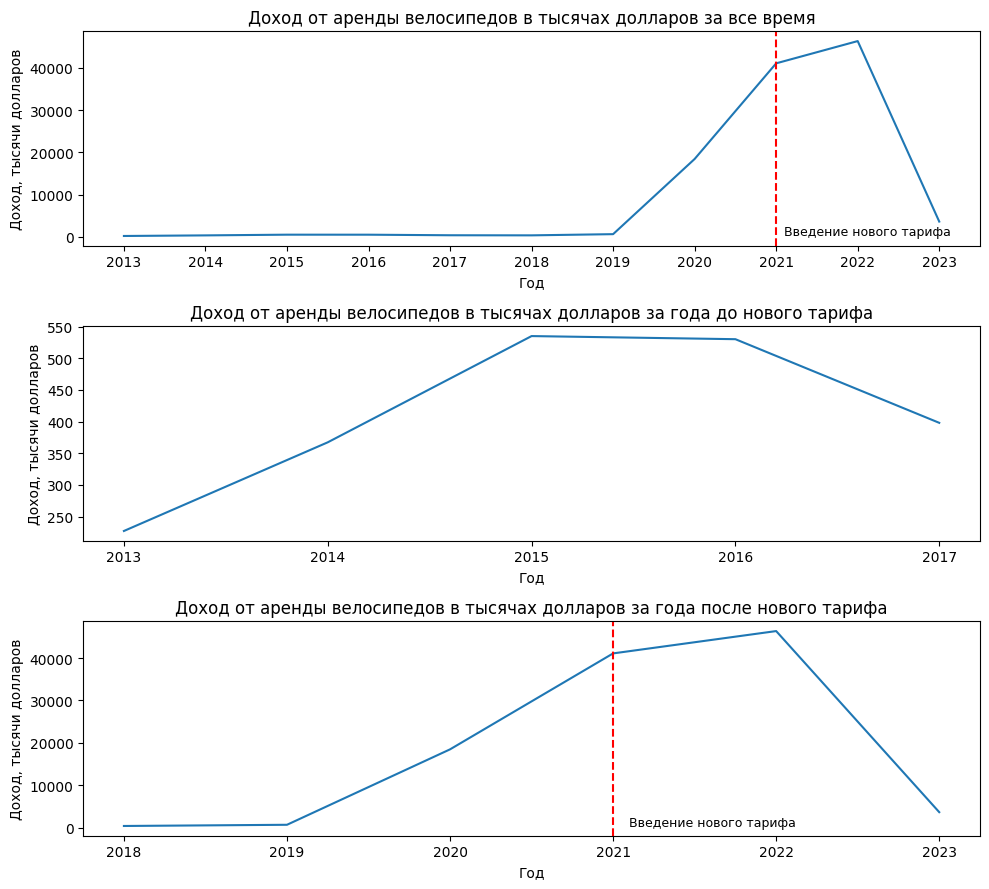

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
axs[0].plot(years, income)
axs[0].set_title("Доход от аренды велосипедов в тысячах долларов за все время")
axs[0].set_xlabel("Год")
axs[0].set_ylabel("Доход, тысячи долларов")
axs[0].axvline(x=2021, color="r", linestyle="--")
axs[0].text(2021.1, 370, "Введение нового тарифа", fontsize=9)
axs[0].set_xticks(years)

axs[1].plot(years_with_first_formula, income_with_first_formula)
axs[1].set_title(
    "Доход от аренды велосипедов в тысячах долларов за года до нового тарифа"
)
axs[1].set_xlabel("Год")
axs[1].set_ylabel("Доход, тысячи долларов")
axs[1].set_xticks(years_with_first_formula)

axs[2].plot(years_with_second_formula, income_with_second_formula)
axs[2].set_title(
    "Доход от аренды велосипедов в тысячах долларов за года после нового тарифа"
)
axs[2].set_xlabel("Год")
axs[2].set_ylabel("Доход, тысячи долларов")
axs[2].set_xticks(years_with_second_formula)
axs[2].axvline(x=2021, color="r", linestyle="--")
axs[2].text(2021.1, 370, "Введение нового тарифа", fontsize=9)
plt.tight_layout()